# Toxic Comments EDA

https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [2]:
#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/duoan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#importing the dataset
trn_df = pd.read_csv("../input/train.csv")
tst_df = pd.read_csv("../input/test.csv")

In [5]:
trn_txt_len = trn_df.comment_text.map(lambda x: len(x))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe584ff9668>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe584ff9d68>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe584ff94e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe5851b54a8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe5851b5828>],
 'means': []}

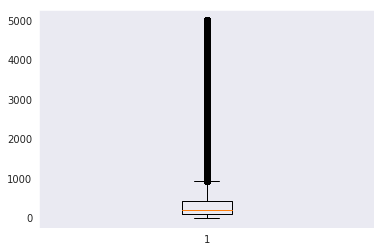

In [6]:
plt.boxplot(trn_txt_len)

In [7]:
!wget http://mkt.tableau.com/files/Sample-Superstore-Subset-Excel.xlsx

--2018-12-14 06:22:33--  http://mkt.tableau.com/files/Sample-Superstore-Subset-Excel.xlsx
Resolving mkt.tableau.com (mkt.tableau.com)... 13.33.148.214, 13.33.148.29, 13.33.148.188, ...
Connecting to mkt.tableau.com (mkt.tableau.com)|13.33.148.214|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mkt.tableau.com/files/Sample-Superstore-Subset-Excel.xlsx [following]
--2018-12-14 06:22:33--  https://mkt.tableau.com/files/Sample-Superstore-Subset-Excel.xlsx
Connecting to mkt.tableau.com (mkt.tableau.com)|13.33.148.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512420 (1.4M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘Sample-Superstore-Subset-Excel.xlsx’

Sample-Superstore-S 100%[===================>]   1.44M  --.-KB/s    in 0.08s   

2018-12-14 06:22:33 (17.8 MB/s) - ‘Sample-Superstore-Subset-Excel.xlsx’ saved [1512420/1512420]



In [8]:
sss = pd.read_excel('./Sample-Superstore-Subset-Excel.xlsx')

In [9]:
sss.head()

,Row ID,Order Priority,Discount,Unit Price,Shipping Cost,Customer ID,Customer Name,Ship Mode,Customer Segment,Product Category,...,Region,State or Province,City,Postal Code,Order Date,Ship Date,Profit,Quantity ordered new,Sales,Order ID
0,18606,Not Specified,0.01,2.88,0.50,2,Janice Fletcher,Regular Air,Corporate,Office Supplies,...,Central,Illinois,Addison,60101,2012-05-28,2012-05-30,1.3200,2,5.90,88525
1,20847,High,0.01,2.84,0.93,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,West,Washington,Anacortes,98221,2010-07-07,2010-07-08,4.5600,4,13.01,88522
2,23086,Not Specified,0.03,6.68,6.15,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,West,Washington,Anacortes,98221,2011-07-27,2011-07-28,-47.6400,7,49.92,88523
3,23087,Not Specified,0.01,5.68,3.60,3,Bonnie Potter,Regular Air,Corporate,Office Supplies,...,West,Washington,Anacortes,98221,2011-07-27,2011-07-28,-30.5100,7,41.64,88523
4,23088,Not Specified,0.00,205.99,2.50,3,Bonnie Potter,Express Air,Corporate,Technology,...,West,Washington,Anacortes,98221,2011-07-27,2011-07-27,998.2023,8,1446.67,88523


In [10]:
sss.columns

Index(['Row ID', 'Order Priority', 'Discount', 'Unit Price', 'Shipping Cost',
       'Customer ID', 'Customer Name', 'Ship Mode', 'Customer Segment',
       'Product Category', 'Product Sub-Category', 'Product Container',
       'Product Name', 'Product Base Margin', 'Region', 'State or Province',
       'City', 'Postal Code', 'Order Date', 'Ship Date', 'Profit',
       'Quantity ordered new', 'Sales', 'Order ID'],
      dtype='object')

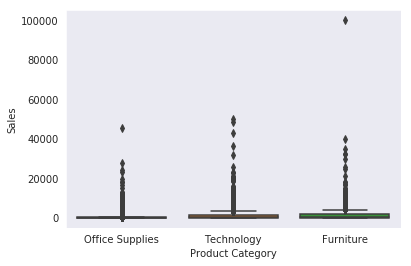

In [14]:
sns.boxplot(y='Sales',x='Product Category', data=sss)

In [17]:
sss.groupby('Product Category')['Sales'].agg(lambda x : np.quantile(x, 0.75) )

Product Category
Furniture          1803.6200
Office Supplies     282.7000
Technology         1504.6025
Name: Sales, dtype: float64

In [23]:
avg = np.mean(sss.groupby('Product Sub-Category')['Sales'].agg('sum'))

In [24]:
sss.groupby('Product Sub-Category')['Sales'].agg('sum') - avg

Product Sub-Category
Appliances                        -69861.115294
Binders and Binder Accessories    111997.894706
Bookcases                         -19089.705294
Chairs & Chairmats                637999.964706
Computer Peripherals              -35743.665294
Copiers and Fax                   134627.734706
Envelopes                        -378663.165294
Labels                           -503134.295294
Office Furnishings                -81960.165294
Office Machines                   692072.394706
Paper                            -272983.885294
Pens & Art Supplies              -423332.605294
Rubber Bands                     -517920.425294
Scissors, Rulers and Trimmers    -486155.325294
Storage & Organization             59120.714706
Tables                            535336.864706
Telephones and Communication      617688.784706
Name: Sales, dtype: float64

In [28]:
x = sss.groupby('Customer ID')['Sales'].agg('sum')


In [30]:
x.sort_values(ascending=False).head(5).index

Int64Index([3075, 308, 2571, 2107, 553], dtype='int64', name='Customer ID')

In [34]:
sum(sss[sss['Customer ID'].isin([3075, 308, 2571, 2107, 553])]['Profit']) / sum(sss['Profit'])

0.026253999978990767

In [35]:
for x in range(10):
    if x % 2 == 0:
        print(x + 1)

1
3
5
7
9


In [39]:
letters = ['x','y','z']
letters.insert(1,'w')
letters[2]

'y'

In [41]:
nums = {1,2,3,4,5,6}
nums = {0,1,2,3} & nums
nums = filter(lambda x:x>1, nums)

list(nums)

[2, 3]

In [44]:
np.find(list(nums)!=0)

AttributeError: module 'numpy' has no attribute 'find'

In [ ]:
np